# Read and examine available stimuli data, export to npy 

In terms of raw stimuli, the music imagery dataset includes:
- WAV files (.wav)
- MIDI used to generate these (.mid)

And for features extracted / related to the stimuli, we are given .MAT files with:
- Acoustic envelopes
- Expectations (surprise), as calculated from statistical / Markov modeling with IDyOM
    - Note expectations exclude notes lying on beat onsets (beginning of each measure)

For more information see the dataset's paper:

Marion, G., Liberto, G. M. D., & Shamma, S. A. (2021). The Music of Silence: Part I: Responses to Musical Imagery Encode Melodic Expectations and Acoustics. Journal of Neuroscience, 41(35), 7435–7448. https://doi.org/10.1523/JNEUROSCI.0183-21.2021

In [1]:
# For file paths
from glob import glob
import os

# Containers and plotting
import matplotlib.pyplot as plt
import numpy as np

# For MAT files
from scipy.io import loadmat
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html

# WAV
from scipy.io import wavfile

# MIDI
import mido # for reading in MIDI, could probably use music21 too
import librosa # for mapping MIDI notes to freq

## Paths to data directories

In [2]:
# for reading in stim data files (.mat, .wav, .mid)
STIM_MAT_PATH = os.path.join('..', '1-source-data', 'datasetCND_musicImagery', 'dataCND', 'dataStim.mat')
STIM_WAV_PATH = os.path.join('..', '1-source-data', 'datasetCND_musicImagery', 'stimuli', 'audio') # glob for .wav below
STIM_MIDI_PATH = os.path.join('..', '1-source-data', 'datasetCND_musicImagery', 'stimuli', 'midi') # glob for .mid below

In [3]:
# for writing out numpy arrays with stim data parsed in this notebook
STIM_NPY_PATH = os.path.join('npy', 'stim')

# Import MAT files
These contain:
- acoustic envelopes
- expectations

In [4]:
stim_mat = loadmat(STIM_MAT_PATH, 
                   simplify_cells = True, # trying this as the struct here is complicated
                   squeeze_me = True
                  ) 
stim = stim_mat['stim']
print(stim.keys())
# How do we read stim? Its an empty-shaped array...

dict_keys(['stimIdxs', 'condIdxs', 'condNames', 'data', 'names', 'fs'])


## Print shapes of all stim array entries

In [5]:
stimIdxs = stim['stimIdxs']
print(f'stimIdxs shape: {stimIdxs.shape}')

condIdxs = stim['condIdxs']
print(f'condIdxs shape: {condIdxs.shape}')

condNames = stim['condNames']
print(f'condNames shape: {condNames.shape}')

data = stim['data']
print(f'data shape: {data.shape}')

names = stim['names']
print(f'names shape: {names.shape}')

fs = stim['fs']
print(f'fs: {fs}')

stimIdxs shape: (88,)
condIdxs shape: (88,)
condNames shape: (2,)
data shape: (2, 88)
names shape: (2,)
fs: 64


## Print stim entries themselves

In [6]:
print(stimIdxs)
print(condIdxs)
print(condNames)
print(names)

[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 4]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
['Listening' 'Imagery']
['Acoustic Envelope' 'Expectation Vector']


## Identify unique conditions (2) and songs (4)

In [7]:
condList = np.unique(condIdxs)
print(f'Unique Conditions: {condList}')

songList = np.unique(stimIdxs)
print(f'Unique Songs: {songList}')

Unique Conditions: [1 2]
Unique Songs: [1 2 3 4]


In [8]:
# Mapping song indices to waves by eyeballing envelopes
song_id_to_name = {}
song_id_to_name[4] = 'chor-019'
song_id_to_name[3] = 'chor-101'
song_id_to_name[1] = 'chor-096'
song_id_to_name[2] = 'chor-038'
song_id_to_name

{4: 'chor-019', 3: 'chor-101', 1: 'chor-096', 2: 'chor-038'}

## Collect data idxs by condition and song

In [9]:
idxs = {} # dict to store idxs for each condition and stim/song idx

for cond in condList: # two conditions
    condName = condNames[cond-1] # MATLAB indexes from 1...
    idxs[condName] = {}
    
    for song in songList:
        
        print(f'{condNames[cond-1]}: Song{song} [{song_id_to_name[song]}]: Indices:') 
        matched_ndx = np.where(
            (stimIdxs == song) & (condIdxs == cond)
            )[0]
        print(matched_ndx)
        
        idxs[condName][song] = matched_ndx

Listening: Song1 [chor-096]: Indices:
[ 0  1  2  3  4  5  6  7  8  9 10]
Listening: Song2 [chor-038]: Indices:
[11 12 13 14 15 16 17 18 19 20 21]
Listening: Song3 [chor-101]: Indices:
[22 23 24 25 26 27 28 29 30 31 32]
Listening: Song4 [chor-019]: Indices:
[33 34 35 36 37 38 39 40 41 42 43]
Imagery: Song1 [chor-096]: Indices:
[44 45 46 47 48 49 50 51 52 53 54]
Imagery: Song2 [chor-038]: Indices:
[55 56 57 58 59 60 61 62 63 64 65]
Imagery: Song3 [chor-101]: Indices:
[66 67 68 69 70 71 72 73 74 75 76]
Imagery: Song4 [chor-019]: Indices:
[77 78 79 80 81 82 83 84 85 86 87]


## Plot acoustic envelopes and expectations for each piece

Stim trials end at 28156.25 ms


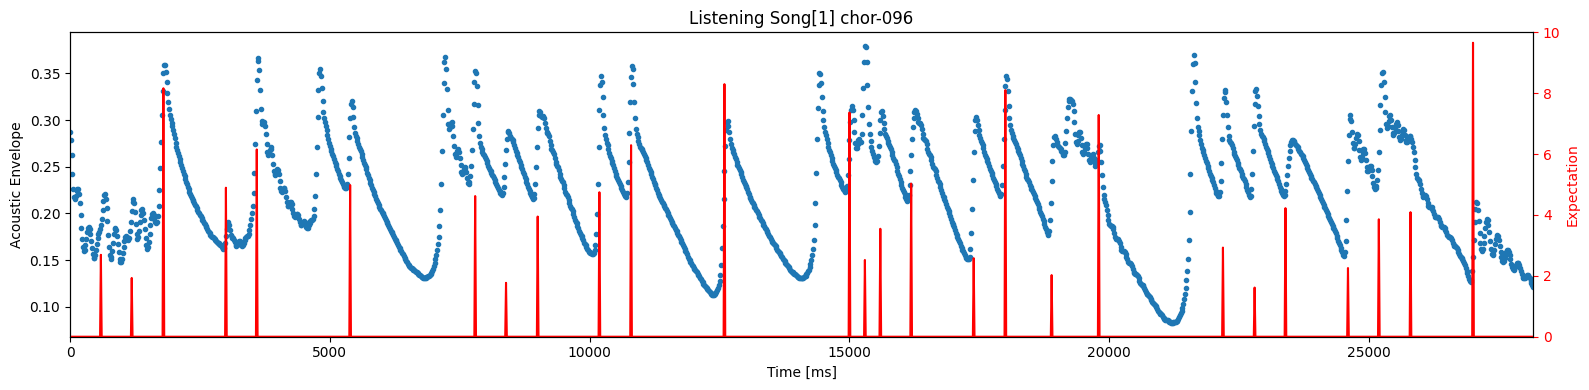

Stim trials end at 28156.25 ms


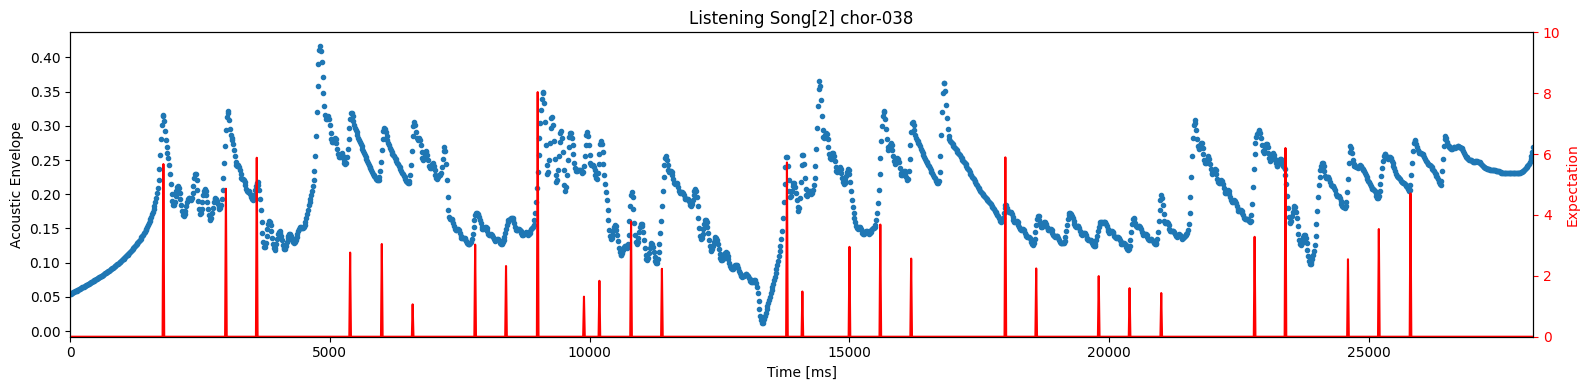

Stim trials end at 28156.25 ms


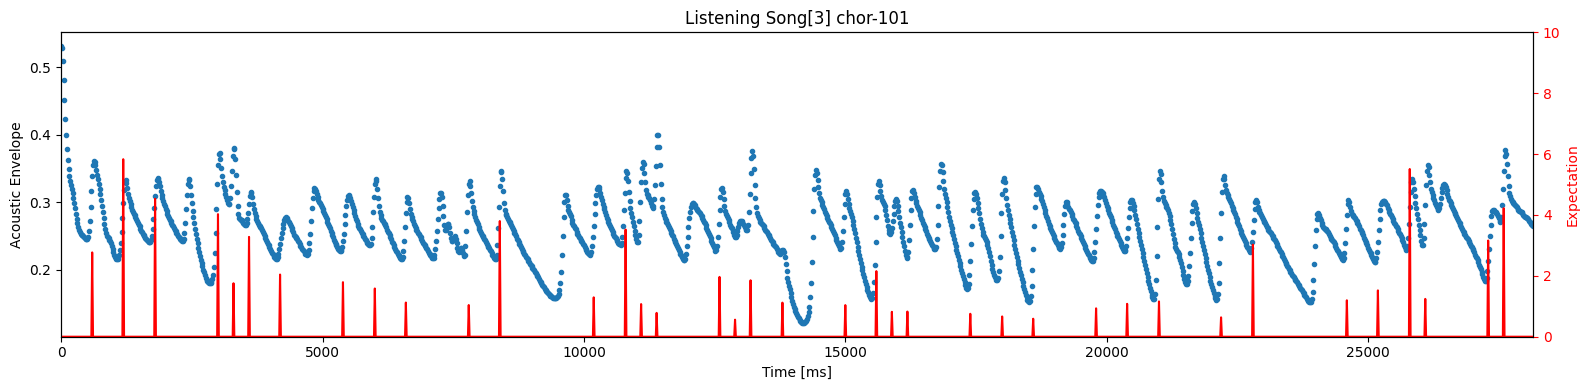

Stim trials end at 28156.25 ms


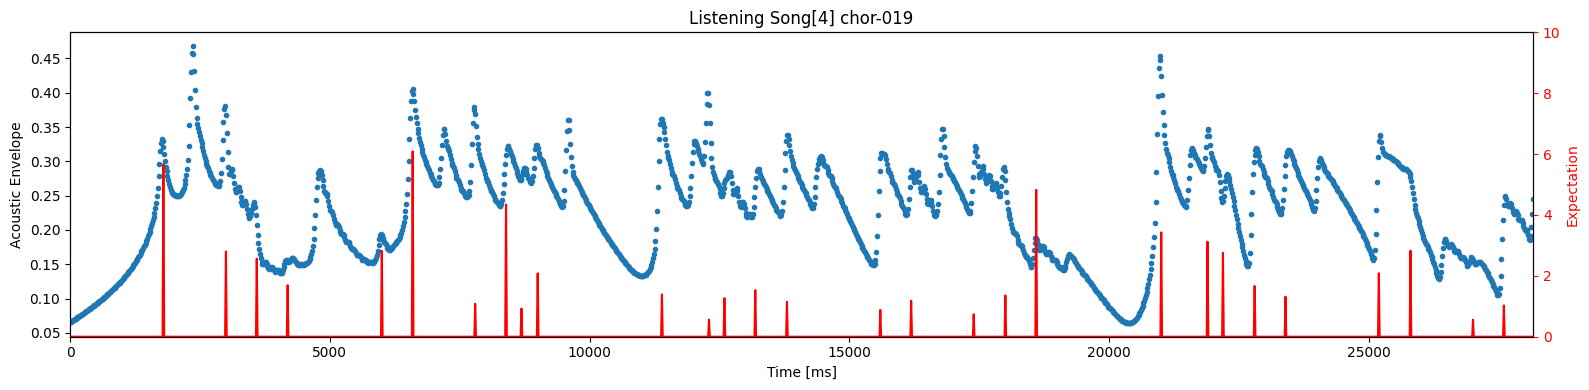

In [10]:
cond = 'Listening' # 'Listening' or 'Imagery'
trial = 0 # 0 to 10

for song in songList: # 1, 2, 3, 4

    envs = data[0][idxs[cond][song][trial]]
    exps = data[1][idxs[cond][song][trial]]

    tt_ms = 1000 * np.arange(start=0, stop=len(exps)/fs, step=1/fs)
    print(f'Stim trials end at {tt_ms[-1]} ms')
    
    # Plot the acoustic envelope
    fig, ax_env = plt.subplots(figsize = (16, 4))
    ax_env.plot(tt_ms, envs, '.')
    ax_env.set_ylabel('Acoustic Envelope')
    plt.xlabel('Time [ms]')

    # Plot the expectations vector
    ax_exp = ax_env.twinx()
    ax_exp.plot(tt_ms, exps, 'r')
    ax_exp.tick_params(axis='y', colors='red')
    ax_exp.yaxis.label.set_color('r')
    ax_exp.set_ylabel('Expectation')
    ax_exp.set_ylim([0, 10])

    plt.xlim([tt_ms[0], tt_ms[-1]])
    plt.title(f'{cond} Song[{song}] {song_id_to_name[song]}')
    plt.tight_layout()
    plt.show()

# Import WAV files
One channel is a metronome / pulse, while the other channel is the actual audio.

In [11]:
waves = glob(STIM_WAV_PATH+'/*.wav', recursive=True)
# print(waves)

MAX_16_BIT = 2**(16-1)

stim_waves = {}

for wav in waves:
    wav_name = wav.split('/')[-1].split('\\')[-1].rstrip('.wav')
    print(wav_name)
    
    fs_wav_Hz, wav_data = wavfile.read(wav)
    num_samples, num_chans = wav_data.shape
    
    stim_waves[wav_name] = {}
    
    stim_waves[wav_name]['time'] = 1000 * np.arange(
        start=0, 
        stop=num_samples/fs_wav_Hz, 
        step=1/fs_wav_Hz)
    
    stim_waves[wav_name]['audio'] = wav_data[:, 1] / MAX_16_BIT
    
    stim_waves[wav_name]['metronome'] = wav_data[:, 0] / MAX_16_BIT

stim_waves

chor-019
chor-038
chor-096
chor-101


{'chor-019': {'time': array([0.00000000e+00, 2.26757370e-02, 4.53514739e-02, ...,
         3.59999320e+04, 3.59999546e+04, 3.59999773e+04], shape=(1587600,)),
  'audio': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 3.05175781e-05, 3.05175781e-05], shape=(1587600,)),
  'metronome': array([0.        , 0.00387573, 0.00769043, ..., 0.        , 0.        ,
         0.        ], shape=(1587600,))},
 'chor-038': {'time': array([0.00000000e+00, 2.26757370e-02, 4.53514739e-02, ...,
         3.59999320e+04, 3.59999546e+04, 3.59999773e+04], shape=(1587600,)),
  'audio': array([3.05175781e-05, 0.00000000e+00, 0.00000000e+00, ...,
         3.05175781e-05, 0.00000000e+00, 0.00000000e+00], shape=(1587600,)),
  'metronome': array([0.        , 0.00384521, 0.00772095, ..., 0.        , 0.        ,
         0.        ], shape=(1587600,))},
 'chor-096': {'time': array([0.00000000e+00, 2.26757370e-02, 4.53514739e-02, ...,
         3.36439002e+04, 3.36439229e+04, 3.364

## Find metronome click (tactile hit) onsets / events
> Finding first samples greater than a threshold value efficiently in Python:
>
> https://stackoverflow.com/a/23882443

dict_keys(['chor-019', 'chor-038', 'chor-096', 'chor-101'])


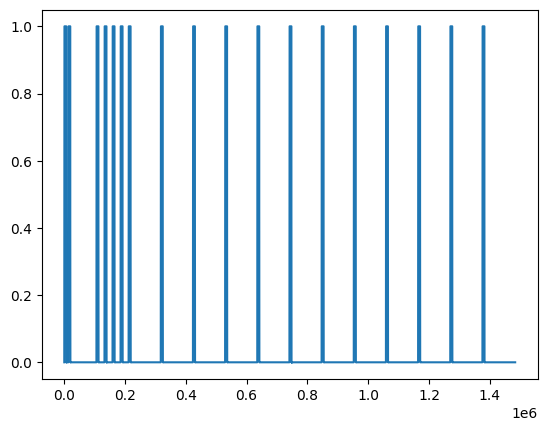

In [12]:
print(stim_waves.keys())
stim_waves[wav_name]['metronome'].shape
plt.plot(stim_waves[wav_name]['metronome'])
plt.show()

## Find start index that aligns MAT stimuli with WAV files

Start ndx: 211681


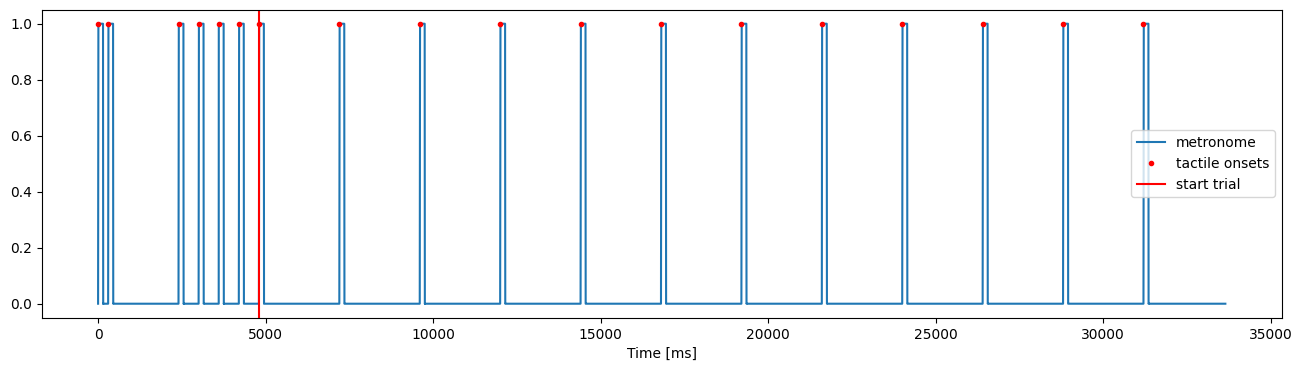

In [13]:
# assuming that the metronome track is identical for all stimuli, take one:
metronome = stim_waves[wav_name]['metronome']

# code idea from https://stackoverflow.com/a/23882443
th = metronome > 0.001
th[1:][th[:-1] & th[1:]] = False
metronome_onsets = stim_waves[wav_name]['time'][th]

# Stim data probably starts with the 6th metronome click
stim_start_ndx = np.where(stim_waves[wav_name]['time'] == metronome_onsets[6])[0][0]
print('Start ndx:', stim_start_ndx)

fig, ax = plt.subplots(figsize=(16, 4))

plt.plot(
    stim_waves[wav_name]['time'],
    stim_waves[wav_name]['metronome'],
    label='metronome')

plt.plot(
    metronome_onsets,
    np.ones_like(metronome_onsets), 
    'r.',
    label='tactile onsets')

plt.axvline(metronome_onsets[6], c='r', label='start trial')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

# Overlay stim data over waves
Goal here was to identify which song ID (1-4) from the stim data structure maps to which wave file (chor-\*.wav).
We also see that expectations for notes with overlapping metronome hits have been zero'd out...

In [14]:
# Mapping song indices to waves by eyeballing envelopes
song_id = {}
song_id['chor-019'] = 4
song_id['chor-101'] = 3
song_id['chor-096'] = 1
song_id['chor-038'] = 2

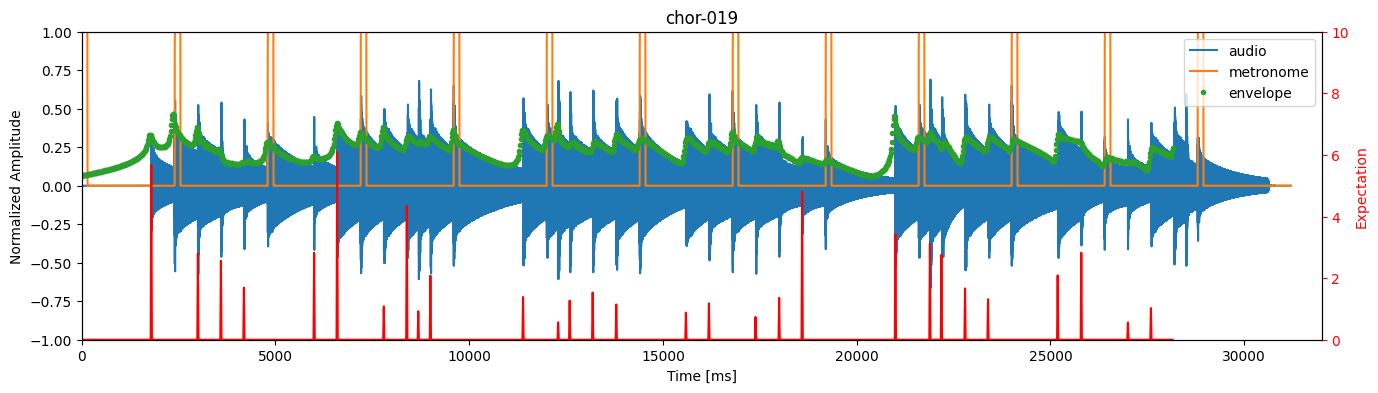

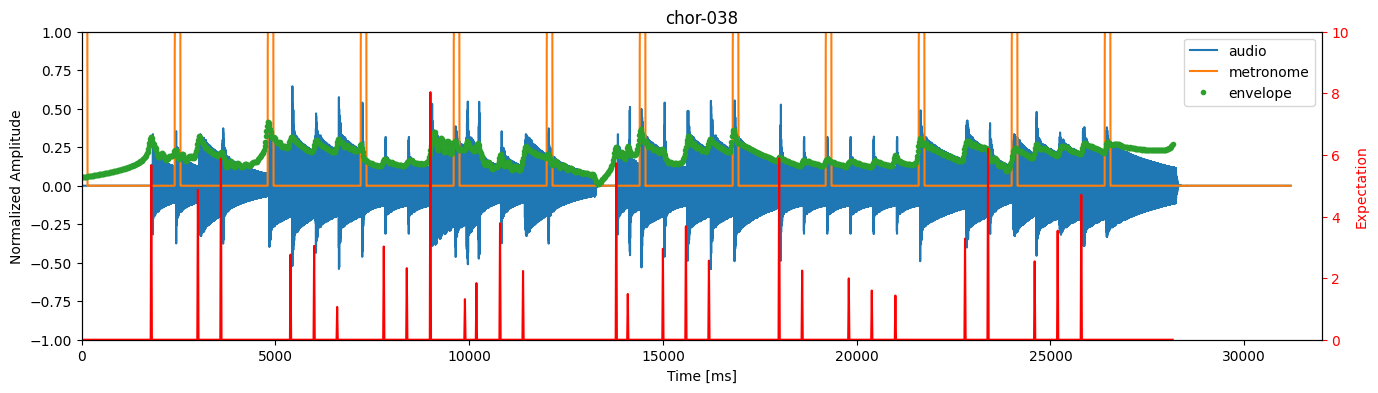

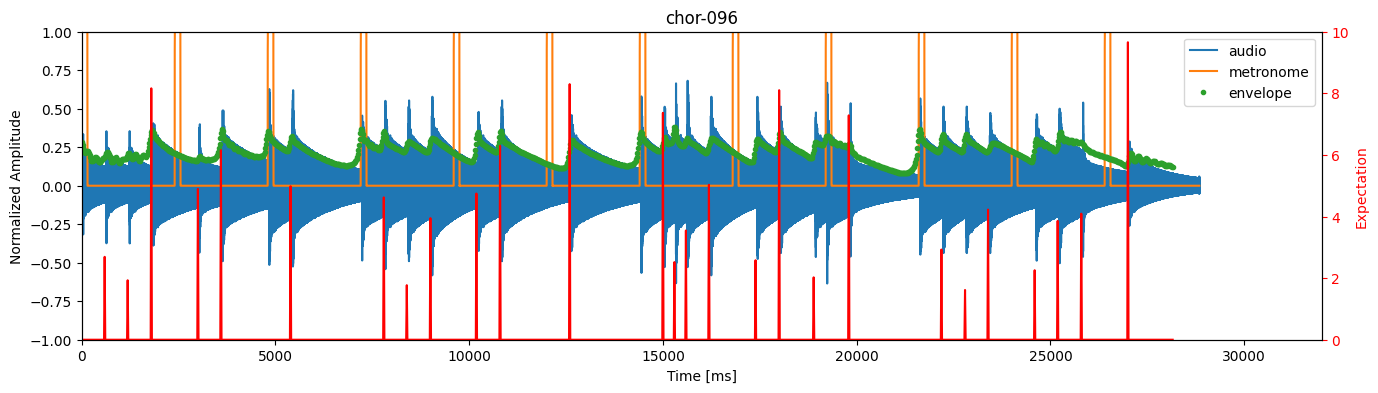

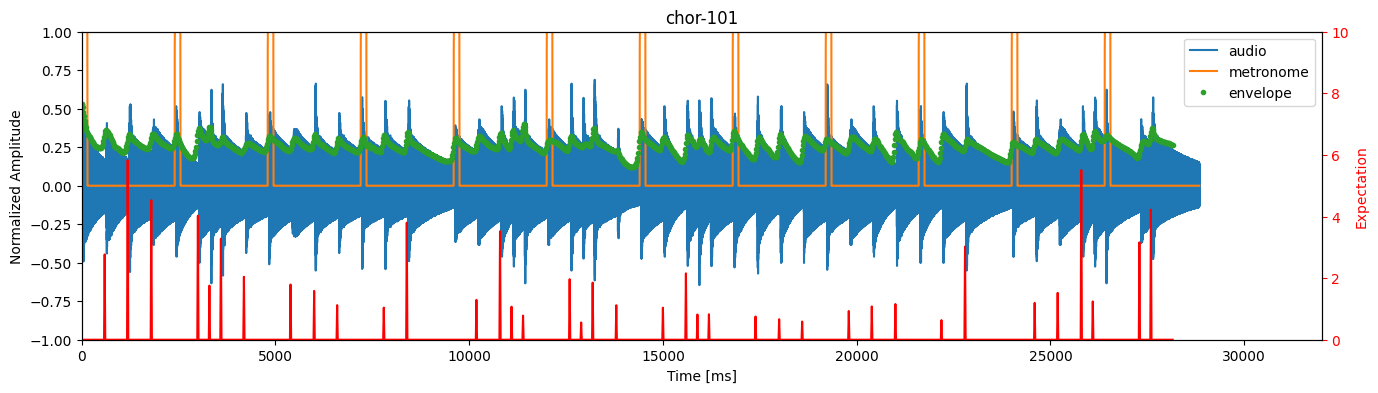

In [15]:
for wav_name in stim_waves.keys():
    truncated_time = np.copy(stim_waves[wav_name]['time'][stim_start_ndx:])
    truncated_time -= metronome_onsets[6] # to start at t=0
    
    fig, ax_env = plt.subplots(figsize=(16,4))
    
    ax_env.plot(
        truncated_time, 
        stim_waves[wav_name]['audio'][stim_start_ndx:], 
        label='audio')
    
    ax_env.plot(
        truncated_time, 
        stim_waves[wav_name]['metronome'][stim_start_ndx:], 
        label='metronome'
    )
    
    song = song_id[wav_name]
    envs = data[0][idxs[cond][song][trial]]
    exps = data[1][idxs[cond][song][trial]]
    ax_env.plot(
        tt_ms, 
        envs, 
        '.',
        label='envelope')
    
    plt.ylim([-1, 1])
    plt.xlabel('Time [ms]')
    plt.ylabel('Normalized Amplitude')
    plt.legend(loc='upper right')
    
    ax_exp = ax_env.twinx()
    ax_exp.plot(tt_ms, exps, 'r')
    ax_exp.tick_params(axis='y', colors='red')
    ax_exp.yaxis.label.set_color('r')
    ax_exp.set_ylabel('Expectation')
    plt.ylim([0, 10])
    

    plt.title(wav_name)
    plt.xlim([0, 32 * 1e3])
    

# Import MIDI files

List all MIDI files in the imagery dataset:

In [16]:
mid_files = glob(os.path.join(STIM_MIDI_PATH, '**.mid'))
mid_files = sorted(mid_files)
mid_files = [mid_files[1], mid_files[2], mid_files[3], mid_files[0]] # rearrange in Score.pdf order
for mid_path in mid_files:
    print(mid_path)


../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-038.mid
../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-096.mid
../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-101.mid
../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-019.mid


Helper function for reading MIDI events

In [17]:
def get_midi_events(mid_path, TICKS_PER_BEAT = 480, print_out = False):
    
    """
    This function generates `mid_events`: a dict of tracks in the MIDI file.
    Each track gets a list of `track_events`.
    Each event in `track_events` is formatted as:
        [MIDI note, start time (ms), stop time (ms)]
        
    This has only been tested on MIDI files where only one note is played at one time (no overlapping notes)
    """
    
    # this will become a dict of tracks (with events) in the MIDI file
    mid_events = {}
    
    # Code here is motivated from examples in mido's documentation:
    # (from https://mido.readthedocs.io/en/latest/midi_files.html)
    
    # Open the MIDI file
    mid = mido.MidiFile(mid_path, ticks_per_beat=TICKS_PER_BEAT)
    
    # Iterate through all tracks and collect 
    # - tempo info
    # - note on/off events
    
    for track_idx, track in enumerate(mid.tracks):
        
        if print_out:
            print('Track {}: {}'.format(track_idx, track.name))
            print('-'*50)
        
        # Timekeeper for the MIDI file
        global_ticks = 0
        
        # Container for collecting all note events
        track_events = []
        
        # Read all the messages for the given track
        for msg in track:
            
            if print_out:
                print(msg)
                    
            # Collect time information for this event
            delta_ticks = msg.time
            global_ticks += delta_ticks
            
            # Check if we have tempo information in this message
            if msg.is_meta and msg.type=='set_tempo':
                    
                # https://mido.readthedocs.io/en/latest/midi_files.html#about-the-time-attribute
                MICROS_PER_BEAT = msg.tempo
                
                if print_out:
                    print(f'>> Tempo (µs/beat): {MICROS_PER_BEAT}')
                
            elif msg.type == 'program_change':
                
                if print_out:
                    # This must be a change of program
                    print(f'>> Program: {msg.program}')
                
            elif 'note' in msg.type: # for both ON and OFF note events
                
                # MIDI number for the note
                NOTE = msg.note 
                
                if msg.type == 'note_on':
                    START_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    event = [NOTE, START_TIME_ms] # note_on event
                    track_events.append(event)
                    
                elif msg.type == 'note_off':
                    STOP_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    
                    # now find the note to turn off in the transcript
                    # this is overkill for a monophonic stimulus
                    for event in track_events:
                        if (NOTE in event) and (len(event)<3): # missing STOP_TIME_ms
                            if STOP_TIME_ms > event[1]: # STOP_TIME_ms is after START_TIME_ms
                                event.append(STOP_TIME_ms)
                
                if print_out:
                    velocity = msg.velocity # same for all notes in this dataset (100) => ignore

                    if msg.type == 'note_on':
                        msg_time_ms = START_TIME_ms
                    elif msg.type == 'note_off':
                        msg_time_ms = STOP_TIME_ms

                    # get the musical note for this event msg
                    import librosa
                    note_symbol = librosa.midi_to_note(NOTE)
                    note_Hz = librosa.midi_to_hz(NOTE)

                    print('>> {}\t{:.3f} Hz\t{}\t{: 4.1f} ms'.format(
                        note_symbol, 
                        note_Hz,
                        global_ticks,
                        msg_time_ms,
                    )
                         )
            
            elif msg.type == 'end_of_track':
                
                if print_out:
                    print('#Ticks:', global_ticks)
                    print('#Events:', len(track_events))
                    print('End of file')
            
            else: # probably the ending message in the MIDI file
                print('Unhandled event type:', msg.type)
                
        mid_events[track_idx] = track_events
        
    return mid_events

Read the MIDI files:

In [18]:
sorted(mid_files)

['../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-019.mid',
 '../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-038.mid',
 '../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-096.mid',
 '../1-source-data/datasetCND_musicImagery/stimuli/midi/chor-101.mid']

In [19]:
TICKS_PER_BEAT = 24 # based on time=72 corresponding to first quarter note F4 in chor-038
song_book = {} # collect all midi scores here

for mid_path in mid_files:
    
    # get song name from the filepath
    song_name = mid_path.split('/')[-1].rstrip('.mid')
    song_book[song_name] = {} # for collecting tracks within the MIDI file
    
    print('='*50)
    print(f'Reading {song_name}...')
    song_book[song_name] = get_midi_events(
        mid_path, 
        TICKS_PER_BEAT, 
        print_out = True
    )

Reading chor-038...
Track 0: 
--------------------------------------------------
MetaMessage('set_tempo', tempo=600000, time=0)
>> Tempo (µs/beat): 600000
program_change channel=1 program=0 time=0
>> Program: 0
note_on channel=1 note=65 velocity=100 time=72
>> F4	349.228 Hz	72	 1800.0 ms
note_off channel=1 note=65 velocity=100 time=24
>> F4	349.228 Hz	96	 2400.0 ms
note_on channel=1 note=65 velocity=100 time=0
>> F4	349.228 Hz	96	 2400.0 ms
note_off channel=1 note=65 velocity=100 time=24
>> F4	349.228 Hz	120	 3000.0 ms
note_on channel=1 note=64 velocity=100 time=0
>> E4	329.628 Hz	120	 3000.0 ms
note_off channel=1 note=64 velocity=100 time=24
>> E4	329.628 Hz	144	 3600.0 ms
note_on channel=1 note=65 velocity=100 time=0
>> F4	349.228 Hz	144	 3600.0 ms
note_off channel=1 note=65 velocity=100 time=48
>> F4	349.228 Hz	192	 4800.0 ms
note_on channel=1 note=69 velocity=100 time=0
>> A4	440.000 Hz	192	 4800.0 ms
note_off channel=1 note=69 velocity=100 time=24
>> A4	440.000 Hz	216	 5400.0 ms
n

Map MIDI notes to frequencies:

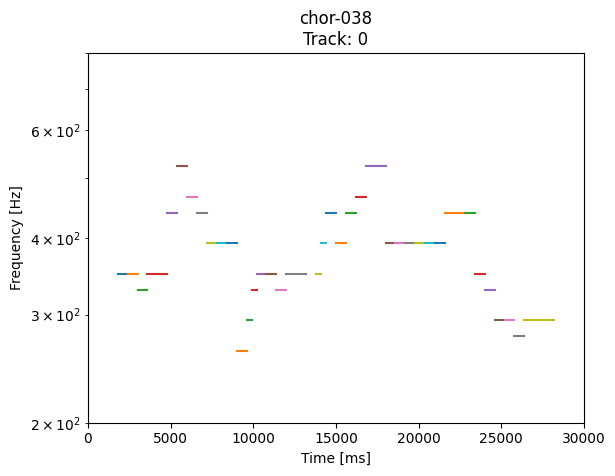

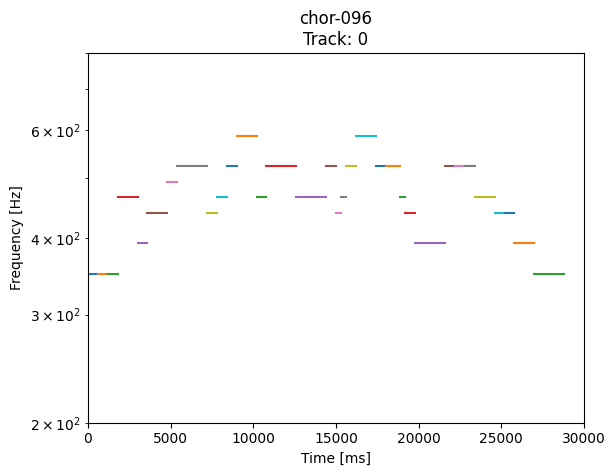

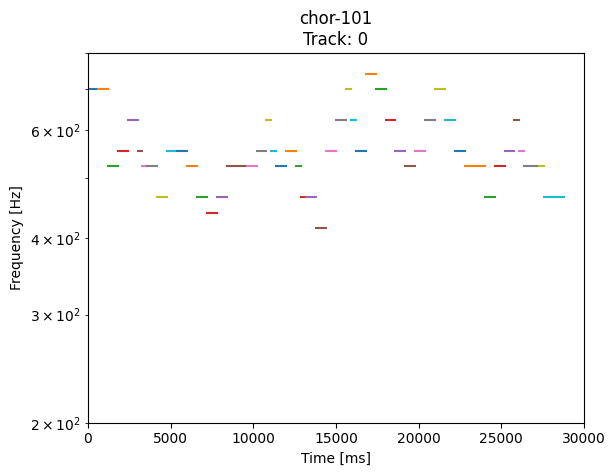

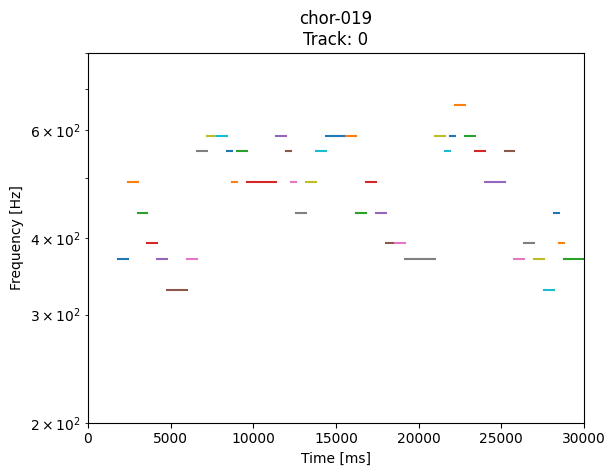

In [20]:
note_labels = {} # map notes to midi values
notes = {} # collects all notes in a song

for song in song_book:
    notes[song] = []
    tracks = song_book[song]
    
    for track in tracks:
        events = song_book[song][track]
        
        plt.figure()
        plt.title(f'{song}\nTrack: {track}')
        
        for event in events:
            # print(event)
            
            NOTE = event[0]
            START_TIME_ms = event[1]
            STOP_TIME_ms = event[2]
            
            FREQ_Hz = librosa.midi_to_hz(NOTE)
            # print(event)
            plt.plot([START_TIME_ms, STOP_TIME_ms], [FREQ_Hz, FREQ_Hz])

            note_label = librosa.midi_to_note(NOTE)
            if note_label not in note_labels.keys():
                note_labels[note_label] = NOTE
                
            notes[song].append(note_label)
            
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        plt.xlim([0, 30000])
        plt.ylim([200, 800])
        plt.yscale('log')

## Map MIDI to 64 Hz samples to match EEG / expectations

In [21]:
1000/(100/60) # millis per quarter note

600.0

In [22]:
1000/fs # time step in millis

15.625

In [23]:
600/15.625 # number of 64Hz samples needed for one quarter note duration

38.4

Map MIDI onsets to closest 64 Hz samples:

In [24]:
song = 'chor-019'
events = song_book[song][0]
onsets_ms = [x[1] for x in events]
onsets_ms = onsets_ms[:-3] # drop the last three notes as they are outside the EEG trial duration provided

onsets_minus_beat = []
for t in onsets_ms:
    if not(t % 2400 == 0):
        onsets_minus_beat.append(t)

np.array(onsets_minus_beat)

array([ 1800.,  3000.,  3600.,  4200.,  6000.,  6600.,  7800.,  8400.,
        8700.,  9000., 11400., 12300., 12600., 13200., 13800., 15600.,
       16200., 17400., 18000., 18600., 21000., 21900., 22200., 22800.,
       23400., 25200., 25800., 27000., 27600.])

Corresponding expectation vector times:

In [25]:
song = song_id['chor-019'] # index
exps = data[1][idxs[cond][song][trial]]
exp_onsets = np.where(exps !=0)[0]
exp_onsets_ms = exp_onsets * 1000 / fs
exp_onsets_ms

array([ 1796.875,  3000.   ,  3593.75 ,  4187.5  ,  6000.   ,  6593.75 ,
        7796.875,  8390.625,  8687.5  ,  9000.   , 11390.625, 12296.875,
       12593.75 , 13187.5  , 13796.875, 15593.75 , 16187.5  , 17390.625,
       18000.   , 18593.75 , 21000.   , 21890.625, 22187.5  , 22796.875,
       23390.625, 25187.5  , 25796.875, 27000.   , 27593.75 ])

Error between expectation vector and MIDI onsets:

In [26]:
error_ms = onsets_minus_beat - exp_onsets_ms
error_ms

array([ 3.125,  0.   ,  6.25 , 12.5  ,  0.   ,  6.25 ,  3.125,  9.375,
       12.5  ,  0.   ,  9.375,  3.125,  6.25 , 12.5  ,  3.125,  6.25 ,
       12.5  ,  9.375,  0.   ,  6.25 ,  0.   ,  9.375, 12.5  ,  3.125,
        9.375, 12.5  ,  3.125,  0.   ,  6.25 ])

In [27]:
max(error_ms)

np.float64(12.5)

(np.float64(510.0),
 np.float64(28890.0),
 np.float64(507.03125),
 np.float64(28887.03125))

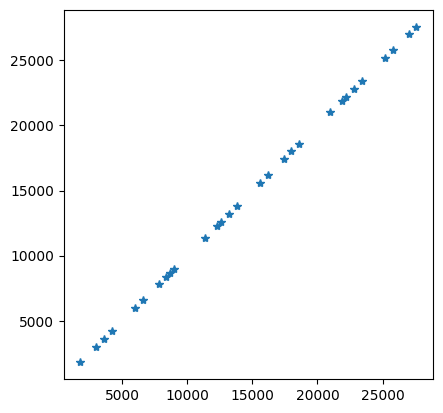

In [28]:
plt.plot(
    onsets_minus_beat, exp_onsets_ms, '*'
)
plt.axis('square')

Look at this error from sample indices instead:

In [29]:
song = 'chor-019'
events = song_book[song][0]
onsets = [x[1]*fs/1000 for x in events]
onsets_sample = np.array(onsets[:-3])

onsets_minus_beat = []
for n in onsets_sample:
    if not(n % 153.6 == 0):
        onsets_minus_beat.append(n)

print('Where MIDI onsets should be (64 Hz sample indices):')
np.array(onsets_minus_beat)

Where MIDI onsets should be (64 Hz sample indices):


array([ 115.2,  192. ,  230.4,  268.8,  384. ,  422.4,  460.8,  499.2,
        537.6,  556.8,  576. ,  729.6,  768. ,  787.2,  806.4,  844.8,
        883.2,  921.6,  998.4, 1036.8, 1075.2, 1113.6, 1152. , 1190.4,
       1344. , 1382.4, 1401.6, 1420.8, 1459.2, 1497.6, 1536. , 1612.8,
       1651.2, 1689.6, 1728. , 1766.4])

In [30]:
song = song_id['chor-019'] # index
exps = data[1][idxs[cond][song][trial]]
exp_onsets = np.where(exps !=0)[0]
print('Expectation vector onsets used (64 Hz sample indices):')
exp_onsets

Expectation vector onsets used (64 Hz sample indices):


array([ 115,  192,  230,  268,  384,  422,  499,  537,  556,  576,  729,
        787,  806,  844,  883,  998, 1036, 1113, 1152, 1190, 1344, 1401,
       1420, 1459, 1497, 1612, 1651, 1728, 1766])

In [31]:
(.8/fs) * 1000 # onset error in millis

12.5

## Map MIDI to expectation vector onsets

In [32]:
t_samples = np.zeros_like(data[1][idxs[cond][1][trial]])
t_samples.shape

(1803,)

Truncate MIDI notes outside of trial duration

In [33]:
midi_traj = {}
REST_NOTE = 1

for song in song_book:
    midi_traj[song] = np.zeros_like(t_samples) # can't map rest events to 0 to detect onset times in MNE, set it to 1 instead.
    midi_traj[song][0] = REST_NOTE # assume we start with rest unless overwritten below

    # Add an extra quarter-note rest as the visual stimulus (Score.pdf) has one
    if song in ['chor-038', 'chor-019']:
        midi_traj[song][76] = REST_NOTE # 76 is the onset of the third quarter-note

    for ev in song_book[song][0]:
        note = ev[0]
        onset = ev[1]*fs/1000
        offset = ev[2]*fs/1000
    
    # updated 2/20: only label note onset
        # so we can identify repeated notes that blend if steps (from offsets) are used
        # : int(np.floor(offset))] = note
        if onset <= len(t_samples):
            midi_traj[song][int(np.floor(onset))] = note 
        if offset <= len(t_samples):
            midi_traj[song][int(np.floor(offset))] = REST_NOTE # can be overwritten by next event

In [34]:
song_book.keys()

dict_keys(['chor-038', 'chor-096', 'chor-101', 'chor-019'])

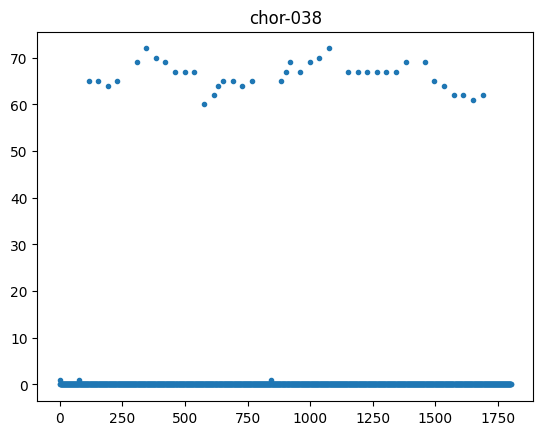

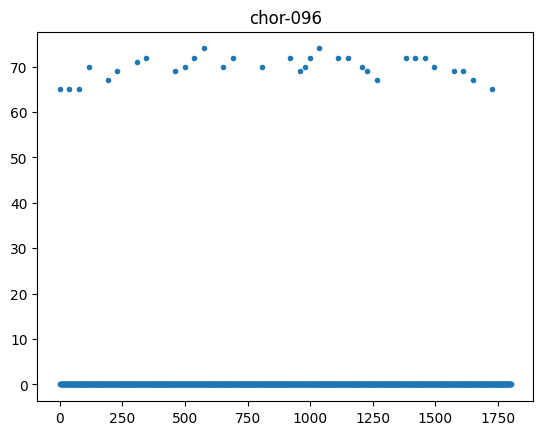

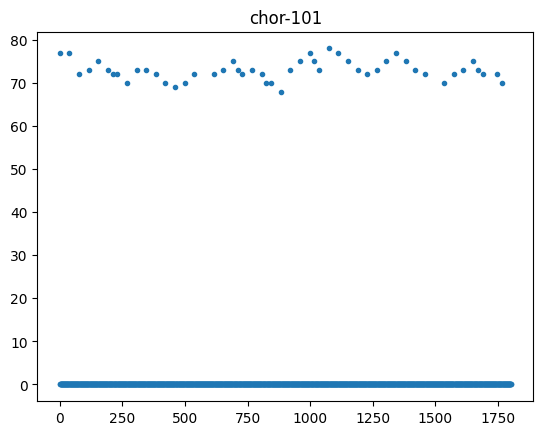

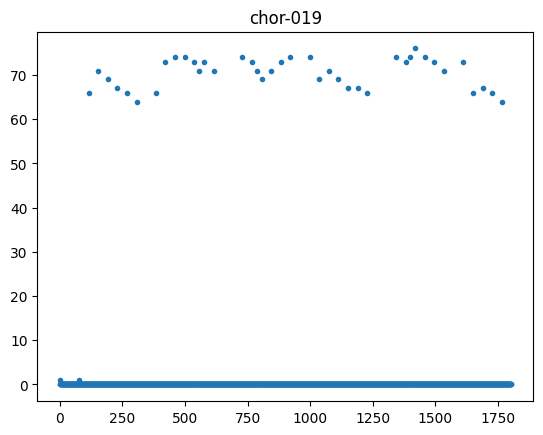

In [35]:
for song in song_book:
    plt.figure()
    plt.plot(midi_traj[song], '.')
    plt.title(song)
    plt.show()

Find metronome / tactile cue onsets:

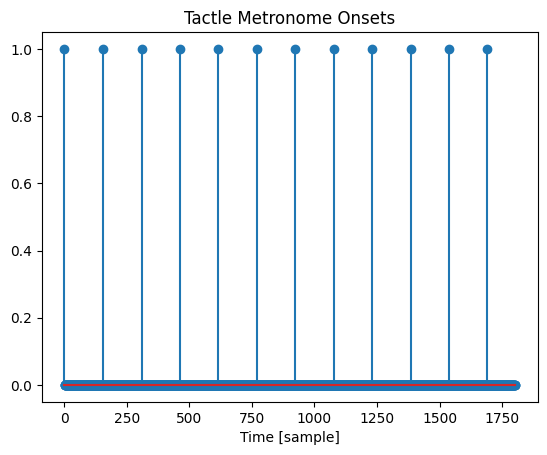

In [36]:
# From Guilhem's note
barOnsets = [1, 157] # in sample indices

cueTime = 310 # third bar
for barIdx in range(10): # 12 bars total
    barOnsets.append(cueTime)
    if barIdx%2 == 1:
        cueTime += 153
    else:
        cueTime += 154

# Make a new exp vector for metronome hits
cueExp = np.zeros_like(t_samples) # same size as the first expectation vector
cueExp[np.array(barOnsets) -1] = 1 # index cueTime from 0

plt.figure()
plt.stem(cueExp, '*')
plt.xlabel('Time [sample]')
plt.title('Tactle Metronome Onsets')
plt.show()

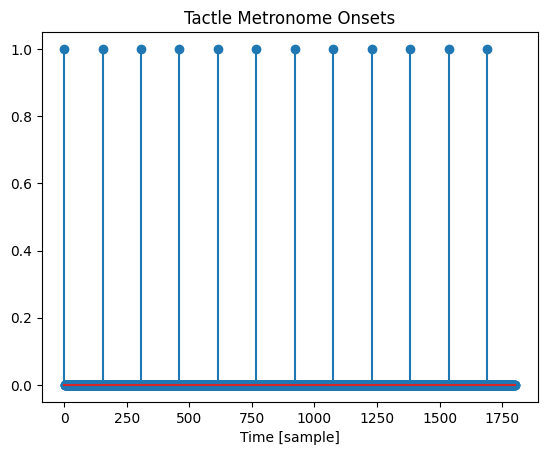

In [37]:
# The above offsets don't seem to line up with the given expectations, instead use the flooring:

barOnsets = [] # in sample indices

cueTime = 0 # first bar
for barIdx in range(12): # 12 bars total
    floored_onset = int(np.floor(cueTime))
    if floored_onset == 1535: # np.floor(153.6*10) seems to mess up from float errors?
        floored_onset = 1536 # fix manually

    barOnsets.append(floored_onset)
    cueTime += 153.6
    
# Make a new exp vector for metronome hits
cueExp = np.zeros_like(t_samples) # same size as the first expectation vector
cueExp[np.array(barOnsets)] = 1 # index cueTime from 0

plt.figure()
plt.stem(cueExp, '*')
plt.xlabel('Time [sample]')
plt.title('Tactle Metronome Onsets')
plt.show()

# Prepare Stim Arrays For Export
Also plot them out

Note, envelopes aren't quite lining up with onsets

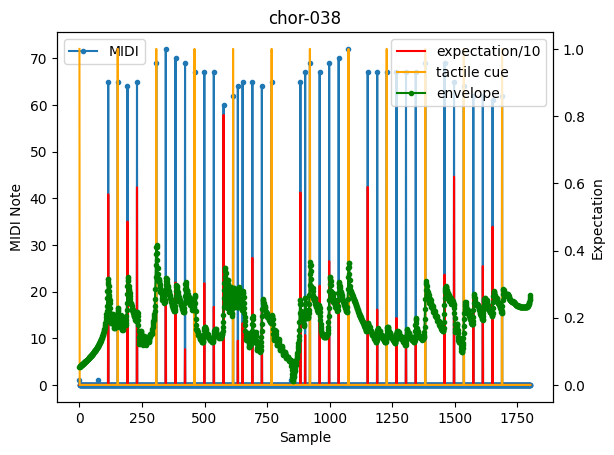

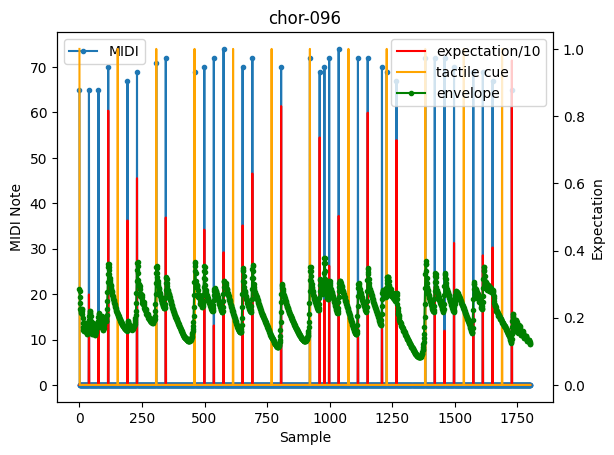

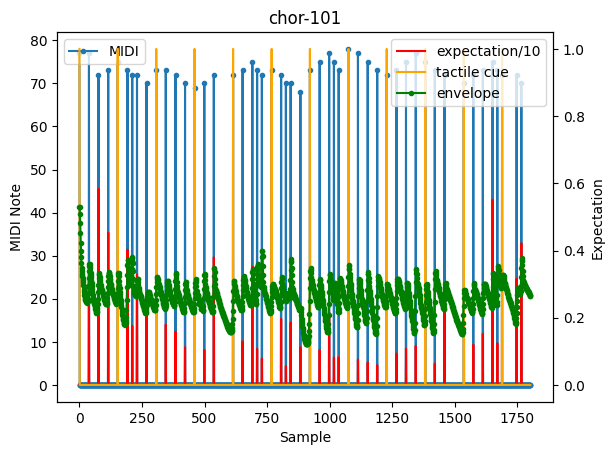

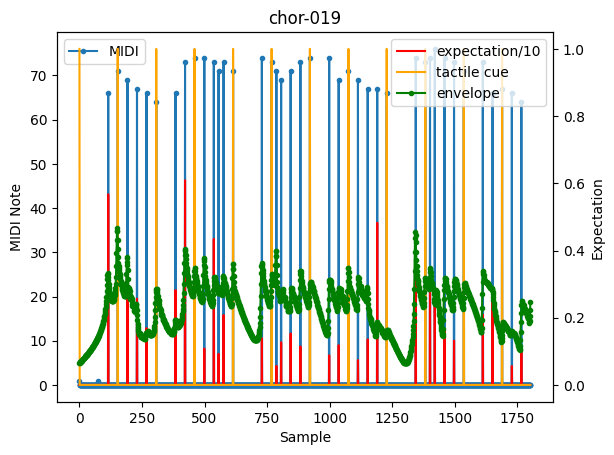

In [39]:
# %matplotlib widget

stims = {}

for song_name in song_book:
    midi_events = midi_traj[song_name]
    exp_events = data[1][idxs[cond][song_id[song_name]][trial]]
    env = data[0][idxs[cond][song_id[song_name]][trial]]
    # cueExp remains the same for all songs


    stims[song_name] = np.vstack(
        (midi_events, exp_events, cueExp, env)
    )

    fig, ax = plt.subplots()
    ax.plot(midi_events, '.-', label='MIDI')
    plt.legend(loc='upper left')
    plt.xlabel('Sample')
    plt.ylabel('MIDI Note')

    ax2 = ax.twinx()
    ax2.plot(exp_events/10, 'r', label='expectation/10')
    ax2.plot(cueExp, 'orange', label='tactile cue')
    ax2.plot(env, 'g.-', label='envelope')

    plt.legend(loc='upper right')
    plt.title(song_name)
    plt.ylabel('Expectation')

In [40]:
stims

{'chor-038': array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.05407348, 0.05469121, 0.05531164, ..., 0.25622297, 0.26207164,
         0.26869736]], shape=(4, 1803)),
 'chor-096': array([[65.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.28676142,  0.27906154,  0.26226445, ...,  0.12532383,
          0.12300036,  0.12128167]], shape=(4, 1803)),
 'chor-101': array([[77.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.       

## Write out stim npy files

In [41]:
for song_name in stims:
    filename = os.path.join(STIM_NPY_PATH, f'{song_name}_fs-{fs}Hz_midi_exp_cue_env.npy')
    np.save(filename, stims[song_name])

In [42]:
stims[song_name].shape

(4, 1803)

In [43]:
stims[song_name][0, :]

array([1., 0., 0., ..., 0., 0., 0.], shape=(1803,))